In [97]:
%reset

# Football Predict
## Questions before start:
We have a bunch of csv files, where each one is divided into categories:
1. Country (belgium, england, france, germany, greece, italy, netherlands, portugal, scotland, spain, turkey)
2. League (0, 1, 2, 3)
3. Season (2000-2001, 2001-2002, ..., 2021-2022)

Should we merge all the csv files into one big dataframe? Or should we keep them separate? 
If we merge them, how do we keep track of the different leagues and seasons?  

## Thoughts:
We could merge them into one big dataframe, and provide analysis on the whole dataset. 
In case we need analyse a specific league or season, we can filter the dataframe accordingly.

**Before merging**, we should add a column for the league and season.


In [98]:
# TODO: 
#  1. try to find in what city match occurred (add as feature), and find related weather data for that city and day (as feature)
#  (DONE) 2. check if particular bookmaker appears only in one (or more) country 
#  (DONE) 3. check if particular bookmaker appears only in one (or more) league
#  (DONE) 4. add weekend/weekday as feature (as "Betting odds for weekend games are collected Friday afternoons, and on Tuesday afternoons for midweek games.")
#  (DONE) 5. add "number of days since last match" as feature
#  (DONE) 6. check correlations in odds across bookmakers, so that we can drop some columns (probably keep only one bookmaker)
#  (DONE) 7. Aggregated columns for bookmakers odds, (min, max, median, mean odd from bookmakers, make column with Interwetten + other so we don't have missing values).
#  (DONE) 8. features from study notebook
#  (DONE) 9. split teams by name
#  (DONE) 10. statistical features based on previous matches (e.g. average goals scored in last 5 matches, average goals conceded in last 5 matches, etc.)
#  (DONE) 11. construct dataframe with all countries, split by league
#  (DONE) 12. input NAs (mean average)
#  13. Modeling: classification – Random Forest, Logistic Regression, SVM
#                regression – Random Forest, Linear Regression, Stepwise Regression, SVM
#  14. Compare models classification: by accuracy, precision, recall, F1 score, ROC curve, AUC
#                     regression: by RMSE, R2, MAE  




In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.impute import SimpleImputer
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [100]:
# csv_files = sorted(glob(f'data/train/**/*.csv', recursive=True))

def read_data(folder_path, mac=False):
    df = pd.DataFrame()
    separator = '/' if mac else '\\'

    for file_path in sorted(glob(f'{folder_path}{separator}**{separator}*.csv', recursive=True)):
        csv_file_df = pd.read_csv(file_path)

        # Extract country, league, and season from file path
        parts = file_path.split(separator)
        country = parts[-3]
        league = int(parts[-2])
        season = int(parts[-1].split('.')[0])
        
        # Skip matches before 1718 season
        if season < 1718:
            continue

        # Rename HT and AT columns to HomeTeam and AwayTeam
        if 'HT' in csv_file_df.columns or 'AT' in csv_file_df.columns:
            csv_file_df.rename(columns={'HT': 'HomeTeam', 'AT': 'AwayTeam'}, inplace=True)
        
        # Add country, league, and season as features to the front
        csv_file_df.insert(0, 'Country', country)
        csv_file_df.insert(1, 'League', league)
        csv_file_df.insert(2, 'Season', season)

        # Convert date to datetime format and sort by date
        csv_file_df['Date'] = pd.to_datetime(csv_file_df['Date'], format='%d/%m/%y', errors='ignore')
        csv_file_df['Date'] = pd.to_datetime(csv_file_df['Date'], format='%d/%m/%Y', errors='coerce')
        csv_file_df = csv_file_df.sort_values(by='Date')

        # Determine if the game is on a weekend or weekday
        # Weekends are typically Saturday (5) and Sunday (6)
        csv_file_df['DayOfWeek'] = csv_file_df['Date'].dt.dayofweek
        csv_file_df['is_Weekend'] = csv_file_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

        df = pd.concat([df, csv_file_df], ignore_index=True, axis=0, join='outer', sort=False)

    return df

In [101]:
# Read all training data
train_df = read_data('../data/train', mac=True)

## Dataset modifications

In [103]:
# get unique team names from all datasets - some teams may be missing in test data
unique_team_names = set()

home_team_names = train_df['HomeTeam'].dropna().unique()
away_team_names = train_df['AwayTeam'].dropna().unique()

unique_team_names = unique_team_names.union(set(home_team_names))
unique_team_names = unique_team_names.union(set(away_team_names))


In [104]:
# create feature over_2.5 based on sum of FTHG and FTAG
train_df['over_2.5'] = ((train_df['FTHG'] + train_df['FTAG']) > 2.5).astype(int)

# drop rows with sum of FTAG + FTHG > 20 or FTAG < 0 or FTHG < 0
train_df = train_df[(train_df['FTHG'] + train_df['FTAG'] <= 20) & (train_df['FTAG'] >= 0) & (train_df['FTHG'] >= 0)]

# drop rows with the same HomeTeam and AwayTeam
train_df = train_df[train_df['HomeTeam'] != train_df['AwayTeam']]

KeyError: 'FTHG'

In [105]:
# Display unique column names and their count
unique_columns = train_df.columns.unique()
column_count = len(unique_columns)

print("Unique Column Names:")
print(unique_columns)

print("\nNumber of Unique Columns:", column_count)

Unique Column Names:
Index(['Country', 'League', 'Season', 'Div', 'Date', 'Time', 'HomeTeam',
       'AwayTeam', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH',
       'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD',
       'VCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5',
       'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5',
       'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH',
       'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH',
       'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH',
       'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA',
       'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5',
       'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH',
       'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH',
       'AvgCAHA', 'DayOfWeek', 'is_Weekend', 'Referee'],
      dtype='object')

Numbe

In [106]:
# Drop empty columns starting with "Unnamed"
train_df = train_df.filter(regex='^(?!Unnamed).*$')


## Column Dicts

In [107]:
# Split columns into categories about match (results data), Match Statistics, and betting odds (as in notes.txt)

match_data = {
    "DayOfWeek": "DayOfWeek",
    "is_Weekend": "is_Weekend",
    "League": "League",
    "Season": "Season",
    "Country": "Country",
    "Div": "League_Division",
    "Date": "Match_Date",
    "Time": "Time_of_match_kick_off",
    "HomeTeam": "Home_Team",
    "AwayTeam": "Away_Team",
    "FTHG": "Full_Time_Home_Team_Goals",
    "FTAG": "Full_Time_Away_Team_Goals",
    "FTR": "Full_Time_Result",
    "HTHG": "Half_Time_Home_Team_Goals",
    "HTAG": "Half_Time_Away_Team_Goals",
    "HTR": "Half_Time_Result"
}

match_statistics = {
    "over_2.5": "over_2.5",
    "Attendance": "Crowd_Attendance",
    "Referee": "Match_Referee",
    "HS": "Home_Team_Shots",
    "AS": "Away_Team_Shots",
    "HST": "Home_Team_Shots_on_Target",
    "AST": "Away_Team_Shots_on_Target",
    "HHW": "Home_Team_Hit_Woodwork",
    "AHW": "Away_Team_Hit_Woodwork",
    "HC": "Home_Team_Corners",
    "AC": "Away_Team_Corners",
    "HF": "Home_Team_Fouls_Committed",
    "AF": "Away_Team_Fouls_Committed",
    "HFKC": "Home_Team_Free_Kicks_Conceded",
    "AFKC": "Away_Team_Free_Kicks_Conceded",
    "HO": "Home_Team_Offsides",
    "AO": "Away_Team_Offsides",
    "HY": "Home_Team_Yellow_Cards",
    "AY": "Away_Team_Yellow_Cards",
    "HR": "Home_Team_Red_Cards",
    "AR": "Away_Team_Red_Cards",
    "HBP": "Home_Team_Bookings_Points",
    "ABP": "Away_Team_Bookings_Points"
}

betting_odds_1x2_match = {
    "B365H": "Bet365_home_win_odds",
    "B365D": "Bet365_draw_odds",
    "B365A": "Bet365_away_win_odds",
    "BSH": "Blue_Square_home_win_odds",
    "BSD": "Blue_Square_draw_odds",
    "BSA": "Blue_Square_away_win_odds",
    "BWH": "Bet&Win_home_win_odds",
    "BWD": "Bet&Win_draw_odds",
    "BWA": "Bet&Win_away_win_odds",
    "GBH": "Gamebookers_home_win_odds",
    "GBD": "Gamebookers_draw_odds",
    "GBA": "Gamebookers_away_win_odds",
    "IWH": "Interwetten_home_win_odds",
    "IWD": "Interwetten_draw_odds",
    "IWA": "Interwetten_away_win_odds",
    "LBH": "Ladbrokes_home_win_odds",
    "LBD": "Ladbrokes_draw_odds",
    "LBA": "Ladbrokes_away_win_odds",
    "PSH": "Pinnacle_home_win_odds",
    "PSD": "Pinnacle_draw_odds",
    "PSA": "Pinnacle_away_win_odds",
    "SOH": "Sporting_Odds_home_win_odds",
    "SOD": "Sporting_Odds_draw_odds",
    "SOA": "Sporting_Odds_away_win_odds",
    "SBH": "Sportingbet_home_win_odds",
    "SBD": "Sportingbet_draw_odds",
    "SBA": "Sportingbet_away_win_odds",
    "SJH": "Stan_James_home_win_odds",
    "SJD": "Stan_James_draw_odds",
    "SJA": "Stan_James_away_win_odds",
    "SYH": "Stanleybet_home_win_odds",
    "SYD": "Stanleybet_draw_odds",
    "SYA": "Stanleybet_away_win_odds",
    "VCH": "VC_Bet_home_win_odds",
    "VCD": "VC_Bet_draw_odds",
    "VCA": "VC_Bet_away_win_odds",
    "WHH": "William_Hill_home_win_odds",
    "WHD": "William_Hill_draw_odds",
    "WHA": "William_Hill_away_win_odds",
    "Bb1X2": "Number_of_BetBrain_bookmakers_used",
    "BbMxH": "Betbrain_maximum_home_win_odds",
    "BbAvH": "Betbrain_average_home_win_odds",
    "BbMxD": "Betbrain_maximum_draw_odds",
    "BbAvD": "Betbrain_average_draw_win_odds",
    "BbMxA": "Betbrain_maximum_away_win_odds",
    "BbAvA": "Betbrain_average_away_win_odds",
    "MaxH": "Market_maximum_home_win_odds",
    "MaxD": "Market_maximum_draw_win_odds",
    "MaxA": "Market_maximum_away_win_odds",
    "AvgH": "Market_average_home_win_odds",
    "AvgD": "Market_average_draw_win_odds",
    "AvgA": "Market_average_away_win_odds",
}

betting_odds_total_goals = {
    "BbOU": "Number_BetBrain_over_under_2.5_goals_averages_and_maximums",
    "BbMx>2.5": "Betbrain_maximum_over_2.5_goals",
    "BbAv>2.5": "Betbrain_average_over_2.5_goals",
    "BbMx<2.5": "Betbrain_maximum_under_2.5_goals",
    "BbAv<2.5": "Betbrain_average_under_2.5_goals",
    "GB>2.5": "Gamebookers_over_2.5_goals",
    "GB<2.5": "Gamebookers_under_2.5_goals",
    "B365>2.5": "Bet365_over_2.5_goals",
    "B365<2.5": "Bet365_under_2.5_goals",
    "P>2.5": "Pinnacle_over_2.5_goals",
    "P<2.5": "Pinnacle_under_2.5_goals",
    "Max>2.5": "Market_maximum_over_2.5_goals",
    "Max<2.5": "Market_maximum_under_2.5_goals",
    "Avg>2.5": "Market_average_over_2.5_goals",
    "Avg<2.5": "Market_average_under_2.5_goals",
}

betting_odds_asian_handicap = {
    "BbAH": "Number_BetBrain_handicap_averages_and_maximums",
    "BbAHh": "Betbrain_size_of_handicap_home_team",
    "AHh": "Market_size_handicap_home_team_since_2019/2020",
    "BbMxAHH": "Betbrain_maximum_Asian_handicap_home_team_odds",
    "BbAvAHH": "Betbrain_average_Asian_handicap_home_team_odds",
    "BbMxAHA": "Betbrain_maximum_Asian_handicap_away_team_odds",
    "BbAvAHA": "Betbrain_average_Asian_handicap_away_team_odds",
    "GBAHH": "Gamebookers_Asian_handicap_home_team_odds",
    "GBAHA": "Gamebookers_Asian_handicap_away_team_odds",
    "GBAH": "Gamebookers_size_of_handicap_home_team",
    "LBAHH": "Ladbrokes_Asian_handicap_home_team_odds",
    "LBAHA": "Ladbrokes_Asian_handicap_away_team_odds",
    "LBAH": "Ladbrokes_size_of_handicap_home_team",
    "B365AHH": "Bet365_Asian_handicap_home_team_odds",
    "B365AHA": "Bet365_Asian_handicap_away_team_odds",
    "B365AH": "Bet365_size_of_handicap_home_team",
    "PAHH": "Pinnacle_Asian_handicap_home_team_odds",
    "PAHA": "Pinnacle_Asian_handicap_away_team_odds",
    "MaxAHH": "Market_maximum_Asian_handicap_home_team_odds",
    "MaxAHA": "Market_maximum_Asian_handicap_away_team_odds",
    "AvgAHH": "Market_average_Asian_handicap_home_team_odds",
    "AvgAHA": "Market_average_Asian_handicap_away_team_odds",
}

closing_odds = {
    'AHCh': 'Market_size_handicap_home_team_since_2019/2020_close',
    'AvgC<2.5': 'Average_under_2.5_goals_close',
    'AvgC>2.5': 'Average_over_2.5_goals_close',
    'AvgCA': 'Away_win_odds_average_close',
    'AvgCAHA': 'Asian_handicap_away_team_odds_average_close',
    'AvgCAHH': 'Asian_handicap_home_team_odds_average_close',
    'AvgCD': 'Draw_odds_average_close',
    'AvgCH': 'Home_win_odds_average_close',
    'B365C<2.5': 'Bet365_under_2.5_goals_close',
    'B365C>2.5': 'Bet365_over_2.5_goals_close',
    'B365CA': 'Bet365_away_win_odds_close',
    'B365CAHA': 'Bet365_Asian_handicap_away_team_odds_close',
    'B365CAHH': 'Bet365_Asian_handicap_home_team_odds_close',
    'B365CD': 'Bet365_draw_odds_close',
    'B365CH': 'Bet365_home_win_odds_close',
    'BWCA': 'Bet&Win_away_win_odds_close',
    'BWCD': 'Bet&Win_draw_odds_close',
    'BWCH': 'Bet&Win_home_win_odds_close',
    'IWCA': 'Interwetten_away_win_odds_close',
    'IWCD': 'Interwetten_draw_odds_close',
    'IWCH': 'Interwetten_home_win_odds_close',
    'MaxC<2.5': 'Market_maximum_under_2.5_goals_close',
    'MaxC>2.5': 'Market_maximum_over_2.5_goals_close',
    'MaxCA': 'Market_maximum_away_win_odds_close',
    'MaxCAHA': 'Market_maximum_Asian_handicap_away_team_odds_close',
    'MaxCAHH': 'Market_maximum_Asian_handicap_home_team_odds_close',
    'MaxCD': 'Market_maximum_draw_odds_close',
    'MaxCH': 'Market_maximum_home_win_odds_close',
    'PC<2.5': 'Pinnacle_under_2.5_goals_close',
    'PC>2.5': 'Pinnacle_over_2.5_goals_close',
    'PCAHA': 'Pinnacle_Asian_handicap_away_team_odds_close',
    'PCAHH': 'Pinnacle_Asian_handicap_home_team_odds_close',
    'PSCA': 'Pinnacle_away_win_odds_close',
    'PSCD': 'Pinnacle_draw_odds_close',
    'PSCH': 'Pinnacle_home_win_odds_close',
    'VCCA': 'VC_Bet_away_win_odds_close',
    'VCCD': 'VC_Bet_draw_odds_close',
    'VCCH': 'VC_Bet_home_win_odds_close',
    'WHCA': 'William_Hill_away_win_odds_close',
    'WHCD': 'William_Hill_draw_odds_close',
    'WHCH': 'William_Hill_home_win_odds_close',
}


In [108]:
# Number of columns in each category
# Combine all sets
col_dicts = [
    betting_odds_asian_handicap,
    betting_odds_total_goals,
    betting_odds_1x2_match,
    match_statistics,
    match_data,
    closing_odds
]

# Calculate the total number of columns in dictionaries
num_col = sum(map(len, col_dicts))

print(f"Number of columns in train_df: {len(train_df.columns)}")
print(f"Number of documented columns: {num_col}")

Number of columns in train_df: 93
Number of documented columns: 169


In [109]:
# Combine all dictionary keys into a single set
col_dicts_keys = set().union(
    betting_odds_asian_handicap.keys(),
    betting_odds_total_goals.keys(),
    betting_odds_1x2_match.keys(),
    match_statistics.keys(),
    match_data.keys(),
    closing_odds.keys()
)

# Get the columns in train_df that are not in the combined set of keys
extra_columns = set(train_df.columns) - col_dicts_keys

# Display the extra columns
print("Columns not present in dictionaries:")
for column in extra_columns:
    print(column)


Columns not present in dictionaries:


Maybe we should drop them, as we don't know what they are.

In [110]:
# Drop the extra columns
train_df = train_df.drop(columns=extra_columns)

Thought: each bookmaker might be assigned to one country, so we can add a column for the country of the bookmaker

In [111]:
# Rename columns in train_df according to the dictionaries
for col_dict in col_dicts:
    train_df.rename(columns=col_dict, inplace=True)
    
# Identify duplicate columns
duplicate_columns = train_df.columns[train_df.columns.duplicated()]

# Print the duplicate columns
print("Duplicate Columns:", duplicate_columns)

Duplicate Columns: Index([], dtype='object')


In [112]:
def calc_moving_avg(df, team_col, goal_col):
    df = df.sort_values(by='Match_Date')
    window_size = 5

    # Calculate moving averages within each group using groupby and transform
    df['MA_Goals'] = df.groupby(team_col)[goal_col].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean().round(2))

    # Extract relevant columns
    moving_avgs = df[[team_col, 'Match_Date', 'MA_Goals']]

    return moving_avgs


home_avg = calc_moving_avg(train_df, "Home_Team", "Full_Time_Home_Team_Goals")
guest_avg = calc_moving_avg(train_df, "Away_Team", "Full_Time_Away_Team_Goals")

# Merge the calculated averages back to the original DataFrame
train_df = train_df.merge(home_avg, how='left', left_on=['Home_Team', 'Match_Date'], right_on=['Home_Team', 'Match_Date'],
                          suffixes=('', '_HomeAvg'))
train_df = train_df.merge(guest_avg, how='left', left_on=['Away_Team', 'Match_Date'], right_on=['Away_Team', 'Match_Date'],
                          suffixes=('', '_GuestAvg'))

# Rename columns for clarity
train_df.rename(columns={'MA_Goals': 'Avg_Home_Goals_Last5', 'MA_Goals_GuestAvg': 'Avg_Away_Goals_Last5'}, inplace=True)

KeyError: 'Column not found: Full_Time_Home_Team_Goals'

In [ ]:

train_df['DaysSinceLastMatchHome'] = 0
train_df['DaysSinceLastMatchAway'] = 0

# Sort the DataFrame by Date
train_df = train_df.sort_values(by='Match_Date')

# Calculate the days since the last match at home for each team
train_df['DaysSinceLastMatchHome'] = train_df.groupby('Home_Team')['Match_Date'].diff().dt.days.fillna(-1).astype(int)

# Calculate the days since the last match away for each team
train_df['DaysSinceLastMatchAway'] = train_df.groupby('Away_Team')['Match_Date'].diff().dt.days.fillna(-1).astype(int)

# Sort the DataFrame back to its original order
train_df = train_df.sort_index()



In [ ]:
# Turn date into epoch Linux time
train_df['Match_Date'] = pd.to_datetime(train_df['Match_Date']).astype(int) / 10 ** 11

In [ ]:
# 2. check if particular bookmaker appears only in one (or more) country
bookmakers = ['Bet365', 
              'Blue_Square', 
              'Bet&Win', 
              'Gamebookers', 
              'Interwetten',
              'Ladbrokes', 
              'Pinnacle', 
              'Sporting_Odds', 
              'Sportingbet', 
              'Stan_James',
              'Stanleybet', 
              'VC_Bet', 
              'William_Hill',
              'Betbrain']

df_test = train_df.copy()
# Create indicator columns for each bookmaker
for bookmaker in bookmakers:
    indicator_column = f'{bookmaker}_indicator'
    columns_to_check = [col for col in df_test.columns if bookmaker in col]
    df_test[indicator_column] = df_test[columns_to_check].any(axis=1).astype(int)

In [ ]:
# List of indicator columns (replace this with your actual indicator columns)
indicator_columns = ['Bet365_indicator', 'Blue_Square_indicator', 'Bet&Win_indicator', 'Gamebookers_indicator',
                     'Interwetten_indicator', 'Ladbrokes_indicator', 'Pinnacle_indicator', 'Sporting_Odds_indicator',
                     'Sportingbet_indicator', 'Stan_James_indicator', 'Stanleybet_indicator', 'VC_Bet_indicator',
                     'William_Hill_indicator', 'Betbrain_indicator']


In [ ]:
# Group by 'Country' and count the occurrences of 1 for each bookmaker
grouped_df = df_test.groupby('Country')[indicator_columns].sum().reset_index()

# Plot a bar chart for each country
for index, row in grouped_df.iterrows():
    country_name = row['Country']
    bookmaker_counts = row[indicator_columns].astype(int)
    bookmaker_name = [bkmkr.split('_indicator')[0] for bkmkr in indicator_columns]

    plt.figure(figsize=(5, 3))
    plt.bar(bookmaker_name, bookmaker_counts, color='skyblue')
    plt.title(f'Bookmaker Counts in {country_name}')
    plt.xlabel('Bookmaker')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

There is no significant difference in bet distribution between the bookmakers per country.

In [ ]:
# Group by 'League' and count the occurrences of 1 for each bookmaker
grouped_df = df_test.groupby('League')[indicator_columns].sum().reset_index()

# Plot a bar chart for each league
for index, row in grouped_df.iterrows():
    league_name = row['League']
    bookmaker_counts = row[indicator_columns].astype(int)
    bookmaker_name = [bkmkr.split('_indicator')[0] for bkmkr in indicator_columns]

    plt.figure(figsize=(5, 3))
    plt.bar(bookmaker_name, bookmaker_counts, color='skyblue')
    plt.title(f'Bookmaker Counts in {league_name} League')
    plt.xlabel('Bookmaker')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

There is no significant difference in bet distribution between the bookmakers per league.

In [113]:
# Group by 'Season' and count the occurrences of 1 for each bookmaker
grouped_df = df_test.groupby('Season')[indicator_columns].sum().reset_index()

# Plot a bar chart for each league
for index, row in grouped_df.iterrows():
    league_name = row['Season']
    bookmaker_counts = row[indicator_columns].astype(int)
    bookmaker_name = [bkmkr.split('_indicator')[0] for bkmkr in indicator_columns]

    plt.figure(figsize=(5, 3))
    plt.bar(bookmaker_name, bookmaker_counts, color='skyblue')
    plt.title(f'Bookmaker Counts in {league_name} Season')
    plt.xlabel('Bookmaker')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

NameError: name 'df_test' is not defined

## Bookmakers odds corelation


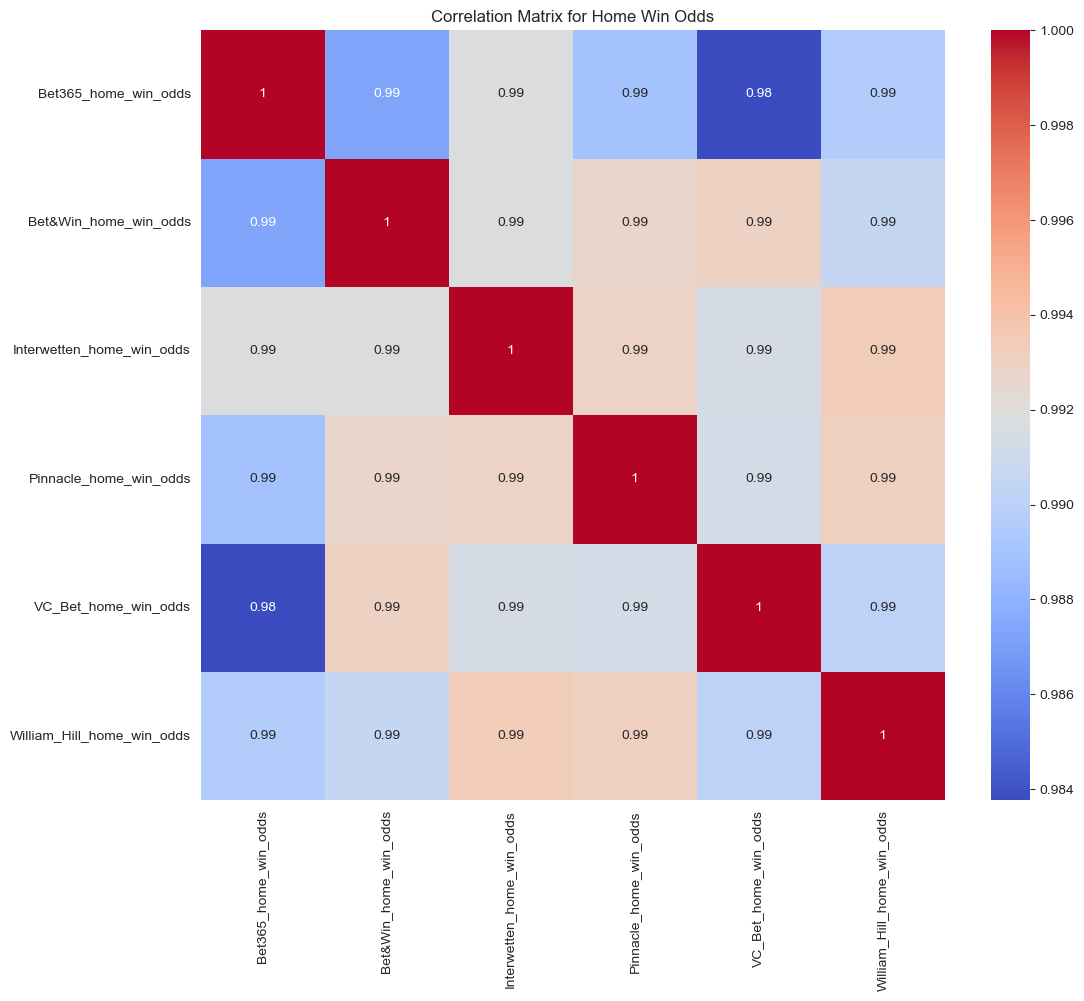

In [114]:

# Selecting home win odds from different bookmakers as an example
home_win_odds_columns = [
    "Bet365_home_win_odds", "Blue_Square_home_win_odds", "Bet&Win_home_win_odds",
    "Gamebookers_home_win_odds", "Interwetten_home_win_odds", "Ladbrokes_home_win_odds",
    "Pinnacle_home_win_odds", "Sporting_Odds_home_win_odds", "Sportingbet_home_win_odds",
    "Stan_James_home_win_odds", "Stanleybet_home_win_odds", "VC_Bet_home_win_odds",
    "William_Hill_home_win_odds"
]

# Filter existing columns
existing_columns = [col for col in home_win_odds_columns if col in train_df.columns]

# Compute the correlation matrix for home win odds
correlation_matrix_home_win = train_df[existing_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_home_win, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Home Win Odds')
plt.show()



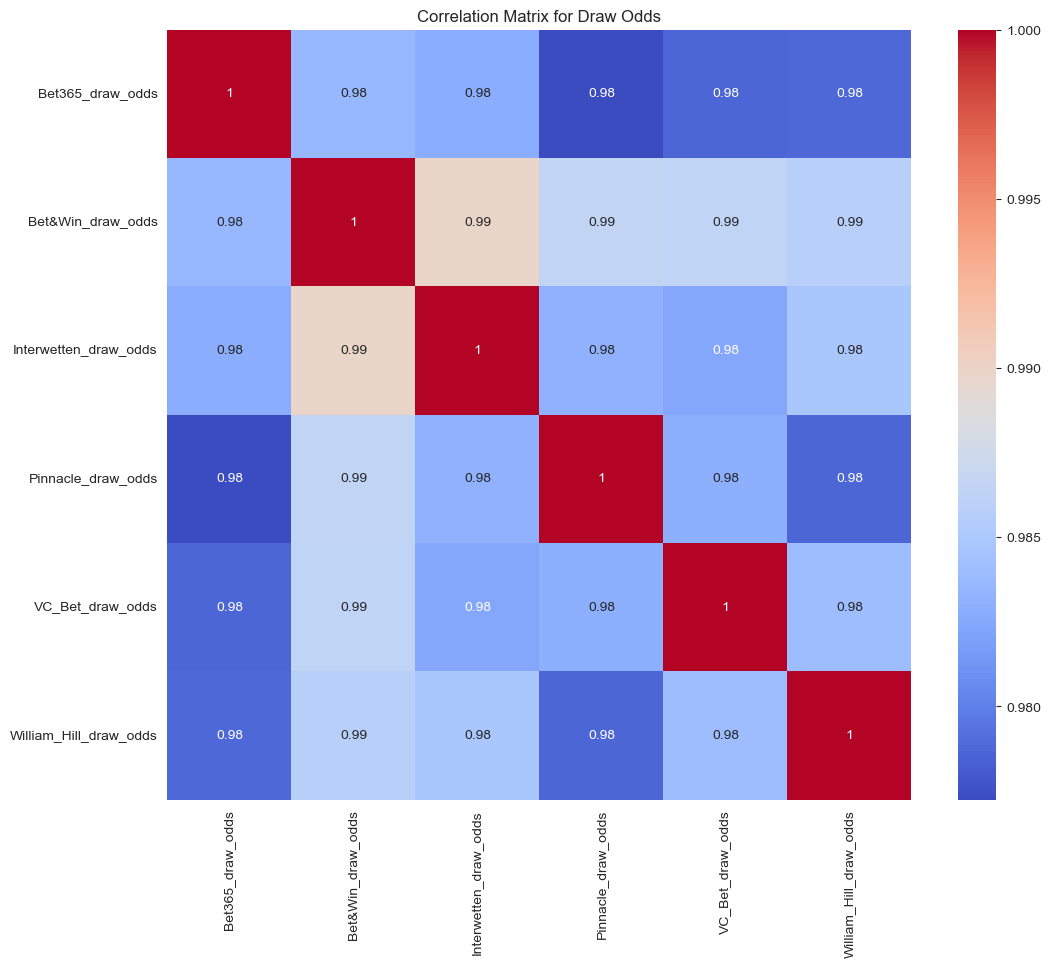

In [115]:
# Selecting draw odds from different bookmakers
draw_odds_columns = [
    "Bet365_draw_odds", "Blue_Square_draw_odds", "Bet&Win_draw_odds",
    "Gamebookers_draw_odds", "Interwetten_draw_odds", "Ladbrokes_draw_odds",
    "Pinnacle_draw_odds", "Sporting_Odds_draw_odds", "Sportingbet_draw_odds",
    "Stan_James_draw_odds", "Stanleybet_draw_odds", "VC_Bet_draw_odds",
    "William_Hill_draw_odds"
]

# Filter existing columns
existing_columns = [col for col in draw_odds_columns if col in train_df.columns]

# Compute the correlation matrix for home win odds
correlation_matrix_draw = train_df[existing_columns].corr()

# Generate a heatmap of the correlation matrix for draw odds
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_draw, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Draw Odds')
plt.show()


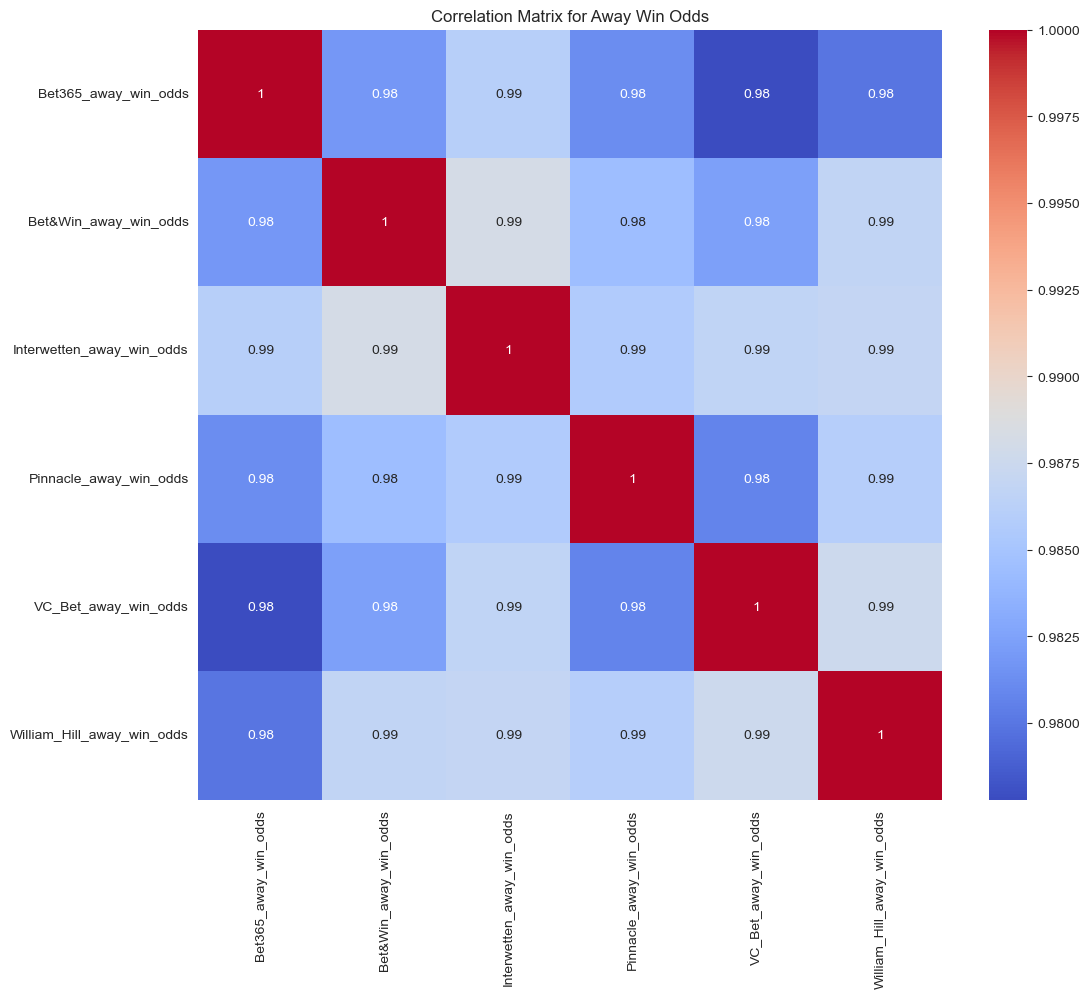

In [116]:
# Selecting away win odds from different bookmakers
away_win_odds_columns = [
    "Bet365_away_win_odds", "Blue_Square_away_win_odds", "Bet&Win_away_win_odds",
    "Gamebookers_away_win_odds", "Interwetten_away_win_odds", "Ladbrokes_away_win_odds",
    "Pinnacle_away_win_odds", "Sporting_Odds_away_win_odds", "Sportingbet_away_win_odds",
    "Stan_James_away_win_odds", "Stanleybet_away_win_odds", "VC_Bet_away_win_odds",
    "William_Hill_away_win_odds"
]

# Filter existing columns
existing_columns = [col for col in away_win_odds_columns if col in train_df.columns]

# Compute the correlation matrix for home win odds
correlation_matrix_away_win = train_df[existing_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_away_win, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Away Win Odds')
plt.show()


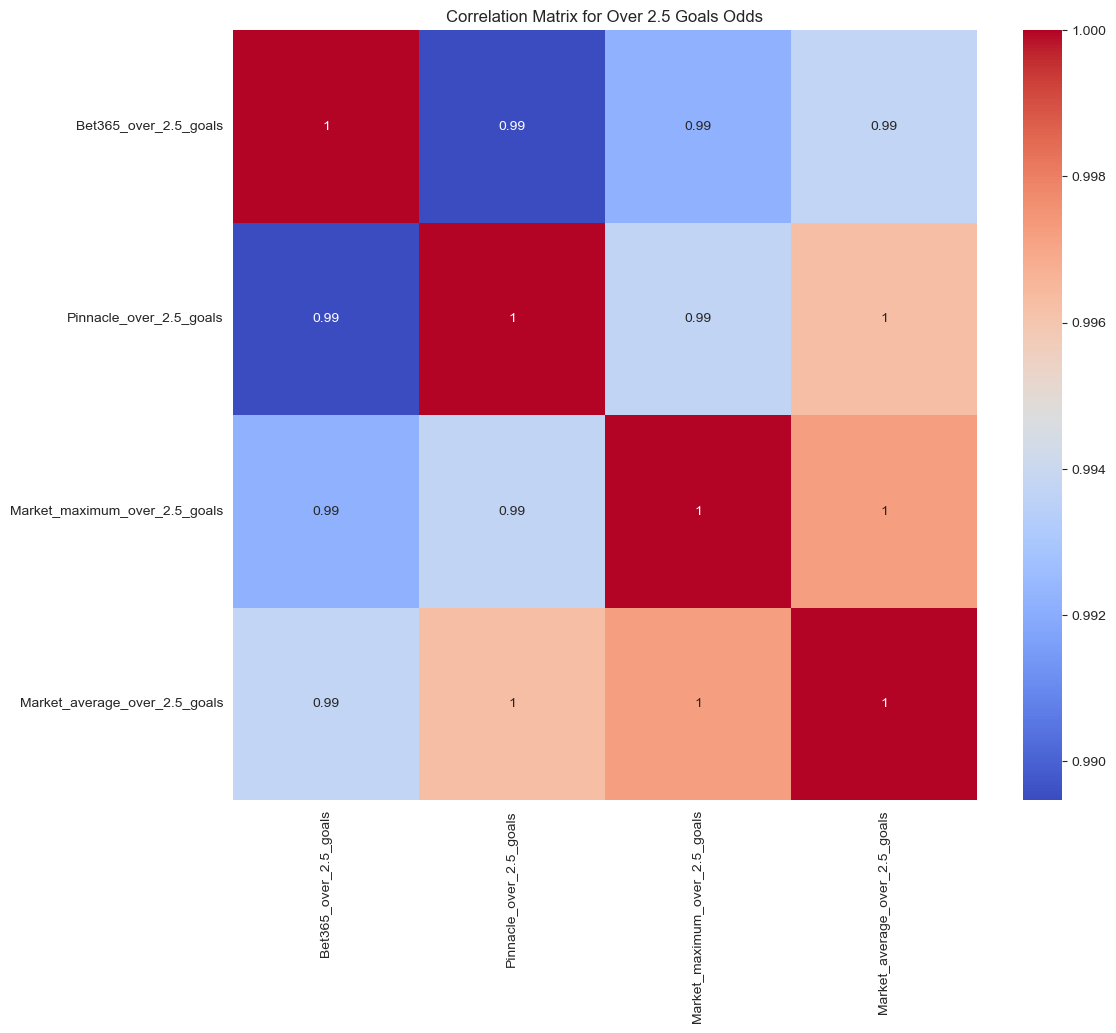

In [117]:
# Selecting over 2.5 goals odds from different bookmakers
over_2_5_goals_columns = [
    "Betbrain_maximum_over_2.5_goals", "Betbrain_average_over_2.5_goals",
    "Gamebookers_over_2.5_goals", "Bet365_over_2.5_goals",
    "Pinnacle_over_2.5_goals", "Market_maximum_over_2.5_goals",
    "Market_average_over_2.5_goals"
]

# Filter existing columns
existing_columns = [col for col in over_2_5_goals_columns if col in train_df.columns]

# Compute the correlation matrix for home win odds
correlation_matrix_over_2_5_goals = train_df[existing_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_over_2_5_goals, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Over 2.5 Goals Odds')
plt.show()


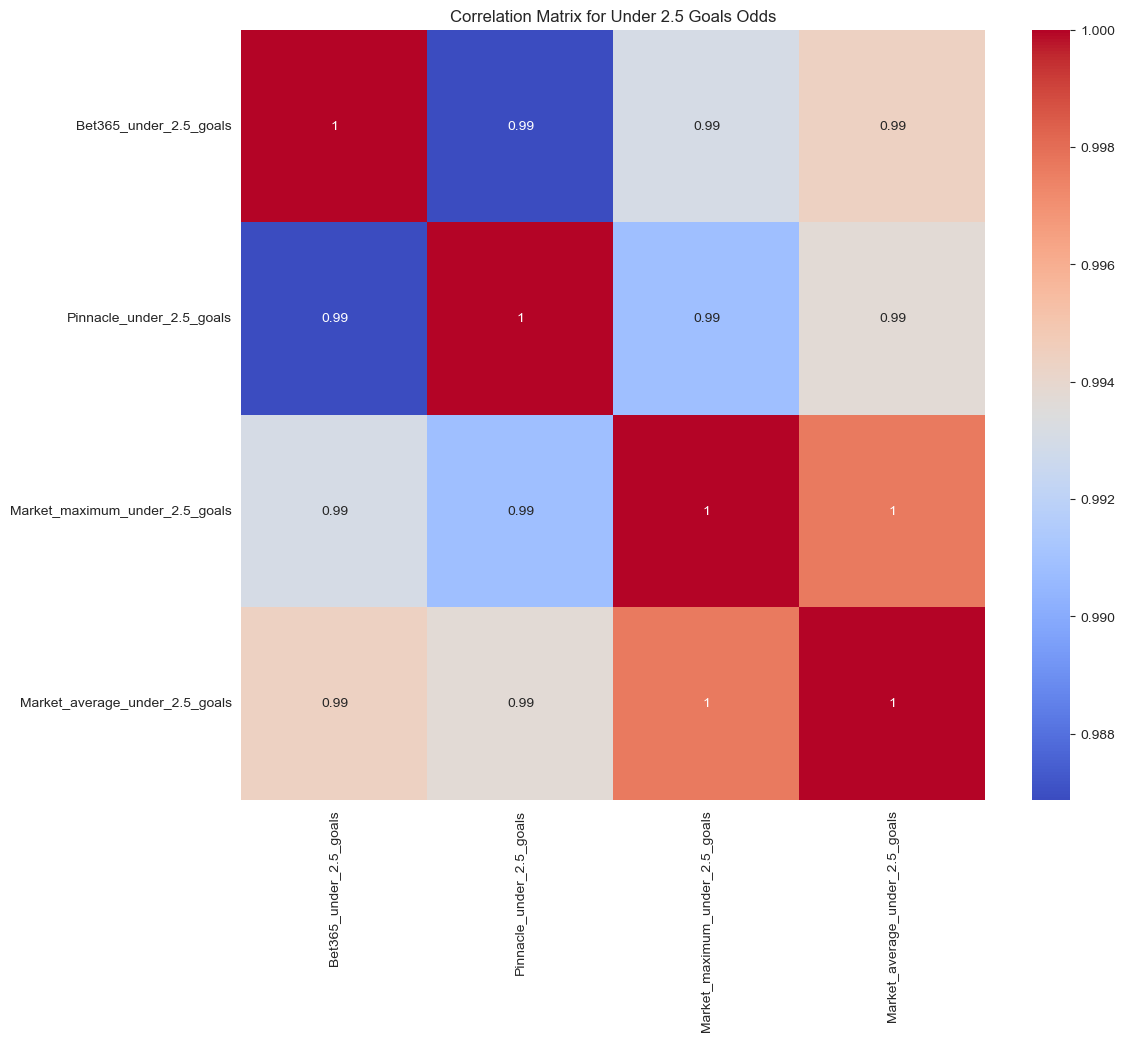

In [118]:
# Selecting under 2.5 goals odds from different bookmakers
under_2_5_goals_columns = [
    "Betbrain_maximum_under_2.5_goals", "Betbrain_average_under_2.5_goals",
    "Gamebookers_under_2.5_goals", "Bet365_under_2.5_goals",
    "Pinnacle_under_2.5_goals", "Market_maximum_under_2.5_goals",
    "Market_average_under_2.5_goals"
]

# Filter existing columns
existing_columns = [col for col in under_2_5_goals_columns if col in train_df.columns]

# Compute the correlation matrix for home win odds
correlation_matrix_under_2_5_goals = train_df[existing_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_under_2_5_goals, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Under 2.5 Goals Odds')
plt.show()


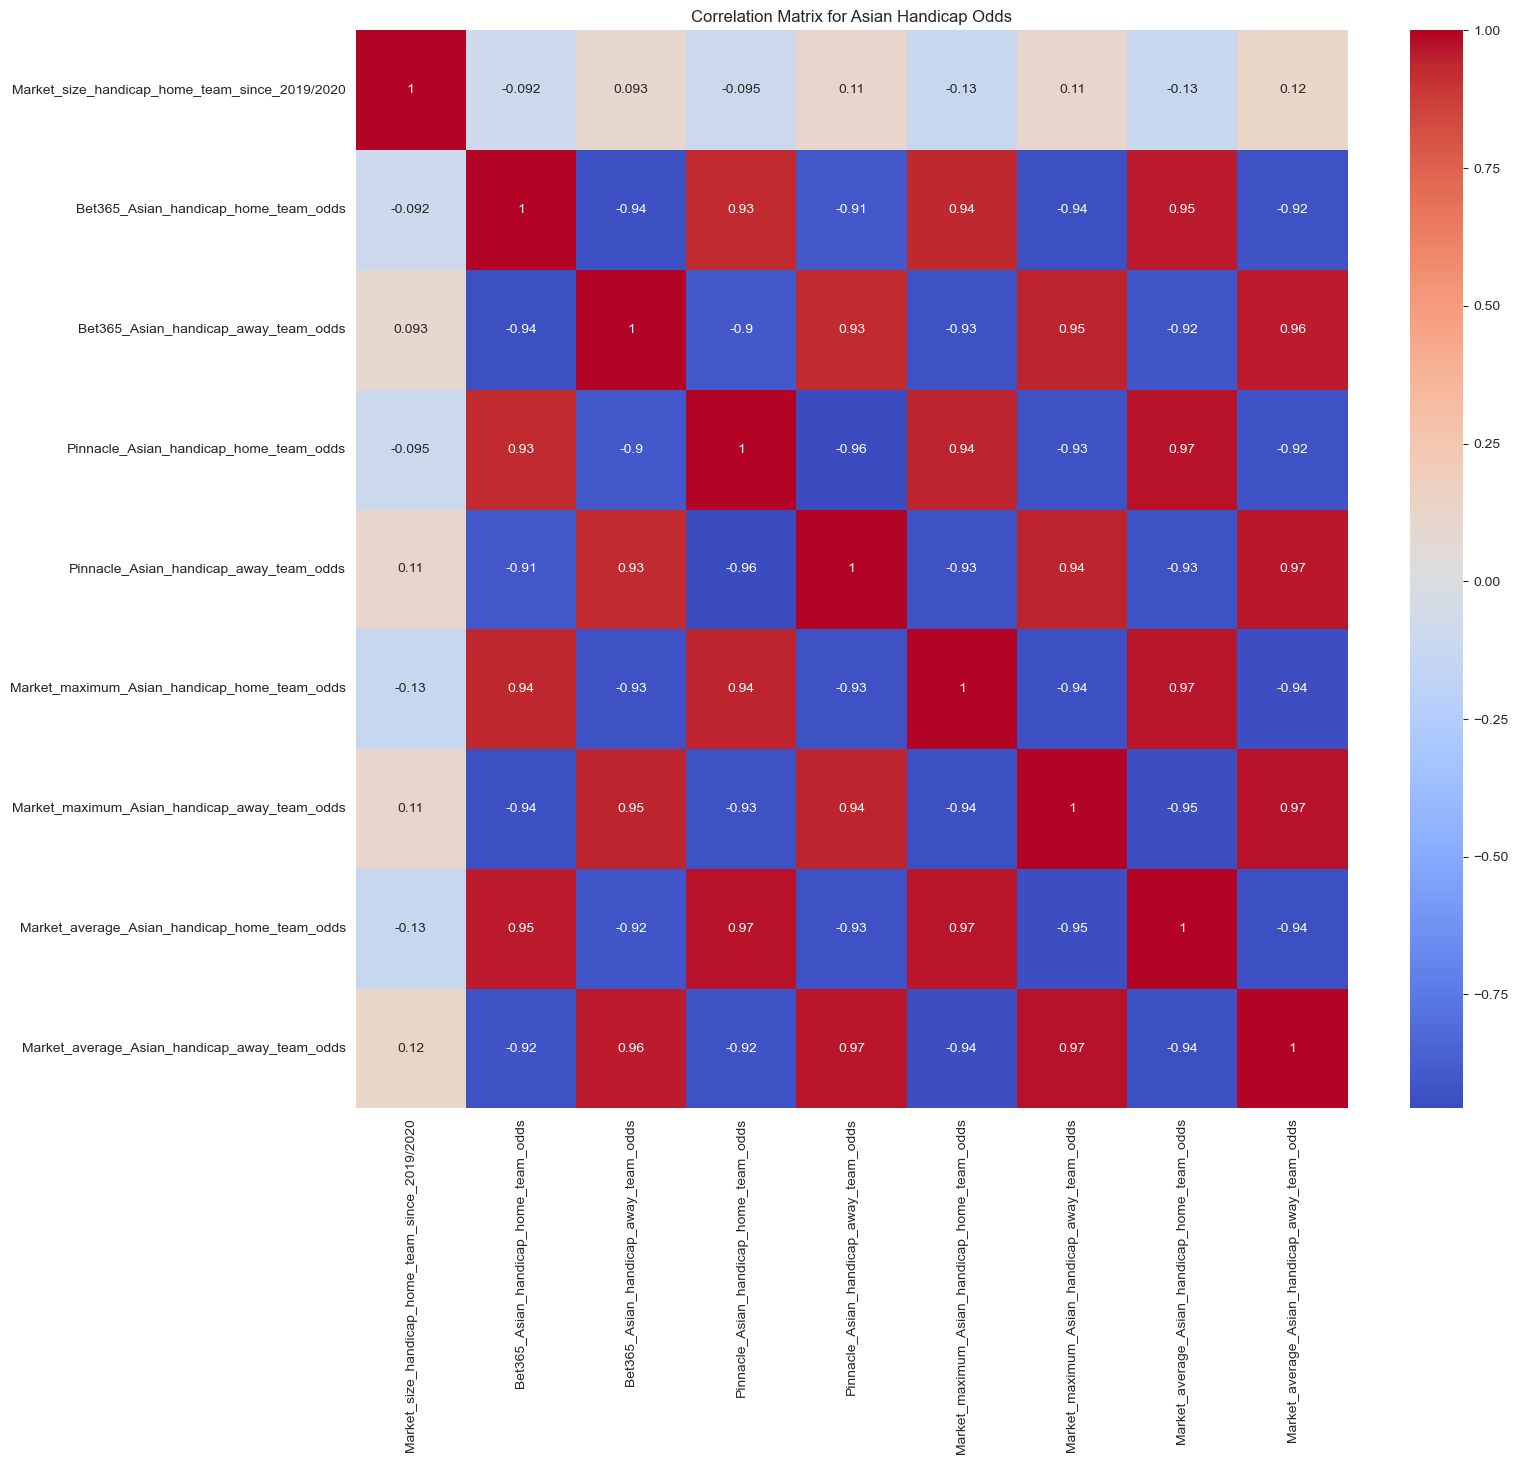

In [119]:
# Selecting Asian handicap odds from different bookmakers
asian_handicap_columns = [
    "Betbrain_size_of_handicap_home_team", "Market_size_handicap_home_team_since_2019/2020",
    "Betbrain_maximum_Asian_handicap_home_team_odds", "Betbrain_average_Asian_handicap_home_team_odds",
    "Betbrain_maximum_Asian_handicap_away_team_odds", "Betbrain_average_Asian_handicap_away_team_odds",
    "Gamebookers_Asian_handicap_home_team_odds", "Gamebookers_Asian_handicap_away_team_odds",
    "Gamebookers_size_of_handicap_home_team", "Ladbrokes_Asian_handicap_home_team_odds",
    "Ladbrokes_Asian_handicap_away_team_odds", "Ladbrokes_size_of_handicap_home_team",
    "Bet365_Asian_handicap_home_team_odds", "Bet365_Asian_handicap_away_team_odds",
    "Bet365_size_of_handicap_home_team", "Pinnacle_Asian_handicap_home_team_odds",
    "Pinnacle_Asian_handicap_away_team_odds", "Market_maximum_Asian_handicap_home_team_odds",
    "Market_maximum_Asian_handicap_away_team_odds", "Market_average_Asian_handicap_home_team_odds",
    "Market_average_Asian_handicap_away_team_odds"
]

# Filter existing columns
existing_columns = [col for col in asian_handicap_columns if col in train_df.columns]

# Compute the correlation matrix for home win odds
correlation_matrix_asian_handicap = train_df[existing_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix_asian_handicap, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Asian Handicap Odds')
plt.show()


## Feature engineering

### Aggregated columns for bookmakers

In [120]:
# Define the columns for home win, away win, and draw odds
home_win_columns = [
    "Bet365_home_win_odds", "Bet&Win_home_win_odds",
    "Interwetten_home_win_odds", "Ladbrokes_home_win_odds",
    "Pinnacle_home_win_odds",  
    "VC_Bet_home_win_odds",
    "William_Hill_home_win_odds", "Betbrain_average_home_win_odds"
]

away_win_columns = [
    "Bet365_away_win_odds", "Bet&Win_away_win_odds",
    "Interwetten_away_win_odds", "Ladbrokes_away_win_odds",
    "Pinnacle_away_win_odds", 
    "VC_Bet_away_win_odds",
    "William_Hill_away_win_odds", "Betbrain_average_away_win_odds"
]

draw_columns = [
    "Bet365_draw_odds", "Bet&Win_draw_odds",
    "Interwetten_draw_odds", "Ladbrokes_draw_odds",
    "Pinnacle_draw_odds", "VC_Bet_draw_odds",
    "William_Hill_draw_odds", "Betbrain_average_draw_win_odds"
]

# Create new features for average home win, away win, and draw odds
train_df["Average_home_win_odds"] = train_df[home_win_columns].mean(axis=1, skipna=True).round(2)
train_df["Average_away_win_odds"] = train_df[away_win_columns].mean(axis=1, skipna=True).round(2)
train_df["Average_draw_odds"] = train_df[draw_columns].mean(axis=1, skipna=True).round(2)

# Display the updated DataFrame with new features
print(train_df.head())

KeyError: "['Ladbrokes_home_win_odds', 'Betbrain_average_home_win_odds'] not in index"

In [ ]:
print("Missing values in Average_home_win_odds:", train_df['Average_home_win_odds'].isna().sum())
print("Missing values in Average_away_win_odds:", train_df['Average_away_win_odds'].isna().sum())
print("Missing values in Average_draw_odds:", train_df['Average_draw_odds'].isna().sum())

In [ ]:
# List of columns to be removed
columns_to_remove = [
    'Blue_Square_home_win_odds', 'Blue_Square_draw_odds', 'Blue_Square_away_win_odds',
    'Gamebookers_home_win_odds', 'Gamebookers_draw_odds', 'Gamebookers_away_win_odds',
    'Sporting_Odds_home_win_odds', 'Sporting_Odds_draw_odds', 'Sporting_Odds_away_win_odds',
    'Sportingbet_home_win_odds', 'Sportingbet_draw_odds', 'Sportingbet_away_win_odds',
    'Stan_James_home_win_odds', 'Stan_James_draw_odds', 'Stan_James_away_win_odds',
    'Stanleybet_home_win_odds', 'Stanleybet_draw_odds', 'Stanleybet_away_win_odds'
]

# Remove the specified columns from betting_odds_1x2_match dictionary
betting_odds_1x2_match = {key: value for key, value in betting_odds_1x2_match.items() if value not in columns_to_remove}


In [ ]:
# Drop the original bookmaker odds columns
train_df = train_df.drop(columns=betting_odds_1x2_match.values())

In [121]:
# Define the columns for over 2.5 goals odds
over_2_5_goals_columns = [
    "Betbrain_average_over_2.5_goals",
    "Bet365_over_2.5_goals",
    "Pinnacle_over_2.5_goals", "Market_average_over_2.5_goals"
]

# Create new feature for average over 2.5 goals odds
train_df["Average_over_2.5_goals_odds"] = train_df[over_2_5_goals_columns].mean(axis=1, skipna=True).round(2)

# Display the updated DataFrame with new feature
print(train_df.head())

KeyError: "['Betbrain_average_over_2.5_goals'] not in index"

In [122]:
print("Missing values in Average_over_2.5_goals:", train_df['Average_over_2.5_goals_odds'].isna().sum())

KeyError: 'Average_over_2.5_goals_odds'

In [123]:
# Define the columns for under 2.5 goals odds
under_2_5_goals_columns = [
    "Betbrain_average_under_2.5_goals",
    "Bet365_under_2.5_goals",
    "Pinnacle_under_2.5_goals", "Market_average_under_2.5_goals"
]

# Create new feature for average under 2.5 goals odds
train_df["Average_under_2.5_goals_odds"] = train_df[under_2_5_goals_columns].mean(axis=1, skipna=True).round(2)

# Display the updated DataFrame with new feature
print(train_df.head())


KeyError: "['Betbrain_average_under_2.5_goals'] not in index"

In [124]:
print("Missing values in Average_under_2.5_goals:", train_df['Average_under_2.5_goals_odds'].isna().sum())

KeyError: 'Average_under_2.5_goals_odds'

In [125]:
# List of columns to be removed
columns_to_remove = ['Gamebookers_over_2.5_goals', 'Gamebookers_under_2.5_goals']

# Remove the specified columns from betting_odds_1x2_match dictionary
betting_odds_total_goals = {key: value for key, value in betting_odds_total_goals.items() if value not in columns_to_remove}

In [126]:
train_df = train_df.drop(columns=betting_odds_total_goals.values())

KeyError: "['Number_BetBrain_over_under_2.5_goals_averages_and_maximums', 'Betbrain_maximum_over_2.5_goals', 'Betbrain_average_over_2.5_goals', 'Betbrain_maximum_under_2.5_goals', 'Betbrain_average_under_2.5_goals'] not found in axis"

In [127]:
# List of columns to be removed
columns_to_remove = ['Gamebookers_Asian_handicap_home_team_odds', 
                     'Gamebookers_size_of_handicap_home_team', 
                     'Ladbrokes_Asian_handicap_home_team_odds', 
                     'Ladbrokes_size_of_handicap_home_team', 'Bet365_size_of_handicap_home_team']

# Remove the specified columns from betting_odds_1x2_match dictionary
betting_odds_asian_handicap = {key: value for key, value in betting_odds_asian_handicap.items() if value not in columns_to_remove}

In [128]:
# Define the Asian handicap columns
asian_handicap_columns = [
    
    
    'Betbrain_average_Asian_handicap_home_team_odds', 
    'Betbrain_average_Asian_handicap_away_team_odds', 'Bet365_Asian_handicap_home_team_odds', 
    'Bet365_Asian_handicap_away_team_odds', 'Pinnacle_Asian_handicap_home_team_odds', 
    'Pinnacle_Asian_handicap_away_team_odds',
    'Market_average_Asian_handicap_home_team_odds', 
    'Market_average_Asian_handicap_away_team_odds'
]

# Split columns by home and away
home_asian_handicap = [
    col for col in asian_handicap_columns if ("home" in col.lower() and "maximum" not in col.lower())
]

away_asian_handicap = [
    col for col in asian_handicap_columns if ("away" in col.lower() and "maximum" not in col.lower())
]

# Create new features for average Asian handicap odds for home and away
train_df["Average_Asian_Handicap_Home_odds"] = train_df[home_asian_handicap].mean(axis=1, skipna=True).round(2)
train_df["Average_Asian_Handicap_Away_odds"] = train_df[away_asian_handicap].mean(axis=1, skipna=True).round(2)

# Display the updated DataFrame with new features
print(train_df.head())


KeyError: "['Betbrain_average_Asian_handicap_home_team_odds'] not in index"

In [ ]:
print("Missing values in Average_Asian_Handicap_Home:", train_df['Average_Asian_Handicap_Home_odds'].isna().sum())
print("Missing values in Average_Asian_Handicap_Away:", train_df['Average_Asian_Handicap_Away_odds'].isna().sum())

In [129]:
train_df = train_df.drop(columns=betting_odds_asian_handicap.values(), errors='ignore')

In [130]:
train_df[closing_odds.values()].isna().sum()

Market_size_handicap_home_team_since_2019/2020_close     29
Average_under_2.5_goals_close                            29
Average_over_2.5_goals_close                             29
Away_win_odds_average_close                              29
Asian_handicap_away_team_odds_average_close              29
Asian_handicap_home_team_odds_average_close              29
Draw_odds_average_close                                  29
Home_win_odds_average_close                              29
Bet365_under_2.5_goals_close                             29
Bet365_over_2.5_goals_close                              29
Bet365_away_win_odds_close                               29
Bet365_Asian_handicap_away_team_odds_close               33
Bet365_Asian_handicap_home_team_odds_close               33
Bet365_draw_odds_close                                   29
Bet365_home_win_odds_close                               29
Bet&Win_away_win_odds_close                              30
Bet&Win_draw_odds_close                 

Most of the columns have more than 40% missing values, so we will drop them. Keep only Pinnacle closing odds.

In [131]:
train_df['Close_home_win_odds'] = train_df['Pinnacle_home_win_odds_close']
train_df['Close_draw_odds'] = train_df['Pinnacle_draw_odds_close']
train_df['Close_away_win_odds'] = train_df['Pinnacle_away_win_odds_close']

In [132]:
train_df = train_df.drop(columns=closing_odds.values())

In [133]:
def determine_favorite(row):
    home_win_odds = row['Average_home_win_odds']
    away_win_odds = row['Average_away_win_odds']

    if abs(home_win_odds - away_win_odds) > 3:
        return 'Home' if home_win_odds < away_win_odds else 'Away'
    else:
        return 'None'


In [134]:
train_df['has_favorite'] = train_df.apply(determine_favorite, axis=1)

KeyError: 'Average_home_win_odds'

### Difference between avg and close odds

In [ ]:
train_df['diff_home_win_odds'] = train_df['Average_home_win_odds'] - train_df['Close_home_win_odds']
train_df['diff_draw_odds'] = train_df['Average_draw_odds'] - train_df['Close_draw_odds']
train_df['diff_away_win_odds'] = train_df['Average_away_win_odds'] - train_df['Close_away_win_odds']

In [ ]:
train_df.drop(columns=['Close_away_win_odds', 'Close_draw_odds', 'Close_home_win_odds'], inplace=True)

## Split dataset by league

In [ ]:
train_df['Time_of_match_kick_off'] = pd.to_datetime(train_df['Time_of_match_kick_off'], format='%H:%M')

In [ ]:
df_league_0 = train_df[train_df['League'] == 0]
df_league_1 = train_df[train_df['League'] == 1]
df_league_2 = train_df[train_df['League'] == 2]
df_league_3 = train_df[train_df['League'] == 3]

In [ ]:
def print_missing_values_summary(df, league_name):
    print(f"\nLeague: {league_name}")
    print("Number of rows:", df.shape[0])

    missing_values = df.isnull().sum()
    total_cells = df.shape[0]
    na_percent = round((missing_values / total_cells) * 100, 2)

    summary_df = pd.DataFrame({
        'column_name': missing_values.index,
        'NA_count': missing_values.values,
        'NA_percent': na_percent.values
    })

    print(summary_df)

### Missing values summary

In [ ]:
# Print missing values summary for each league
print_missing_values_summary(df_league_0, 0)

In [ ]:
print_missing_values_summary(df_league_1, 1)

In [ ]:
print_missing_values_summary(df_league_2, 2)

In [ ]:
print_missing_values_summary(df_league_3, 3)

## Impute missing values in Time_of_match_kick_off

In [ ]:
train_df['Time_of_match_kick_off'].value_counts()

In [ ]:
time_bins = ['Morning', 'Afternoon', 'Evening', 'Late Evening']
bin_edges = [datetime.strptime('00:00', '%H:%M'), datetime.strptime('13:00', '%H:%M'),
             datetime.strptime('16:00', '%H:%M'), datetime.strptime('19:00', '%H:%M'),
             datetime.strptime('23:59', '%H:%M')]

# Function to create time distribution plot
def plot_time_distribution(df, title):
    sorted_df = df.sort_values('Time_of_match_kick_off')

    plt.figure(figsize=(12, 8))
    sns.countplot(x=sorted_df['Time_of_match_kick_off'].dt.strftime('%H:%M'))
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.title(title)
    plt.xlabel('Kick-off Time')
    plt.ylabel('Count')
    plt.show()

# Function to create time bins distribution plot
def plot_time_bins_distribution(df, title):
    
    # Bin the 'Time_of_match_kick_off' column
    df['Time_kick_off_bin'] = pd.cut(df['Time_of_match_kick_off'], bins=bin_edges, labels=time_bins)

    plt.figure(figsize=(12, 8))
    sns.countplot(x=df['Time_kick_off_bin'])
    plt.title(title)
    plt.xlabel('Kick-off Time')
    plt.ylabel('Count')
    plt.show()

In [ ]:
plot_time_distribution(train_df, "Distribution of Match Kick-off Times for All Leagues")
plot_time_bins_distribution(train_df, "Distribution of Match Kick-off Times for All Leagues")

In [ ]:
plot_time_distribution(df_league_0, f'Distribution of Match Kick-off Times - League 0')
plot_time_bins_distribution(df_league_0, f'Distribution of Match Kick-off Times - League 0')

In [ ]:
plot_time_distribution(df_league_1, f'Distribution of Match Kick-off Times - League 1')
plot_time_bins_distribution(df_league_1, f'Distribution of Match Kick-off Times - League 1')

In [ ]:
plot_time_distribution(df_league_2, f'Distribution of Match Kick-off Times - League 2')
plot_time_bins_distribution(df_league_2, f'Distribution of Match Kick-off Times - League 2')

In [ ]:
plot_time_distribution(df_league_3, f'Distribution of Match Kick-off Times - League 3')
plot_time_bins_distribution(df_league_3, f'Distribution of Match Kick-off Times - League 3')

In [ ]:
def categorize_time(time_value):
    for i in range(len(bin_edges) - 1):
        if bin_edges[i] <= time_value < bin_edges[i + 1]:
            return time_bins[i]
    # If none of the bins match, return 'Afternoon'
    return 'Afternoon'


In [135]:
# Apply the function to create a new column 'Time_bin'
train_df['Time_kick_off_bin'] = train_df['Time_of_match_kick_off'].apply(categorize_time)
train_df.drop(columns=['Time_of_match_kick_off'], inplace=True)

NameError: name 'categorize_time' is not defined

In [136]:
train_df['Time_kick_off_bin'].isna().sum()

KeyError: 'Time_kick_off_bin'

In [137]:
df_league_0['Time_kick_off_bin'] = df_league_0['Time_of_match_kick_off'].apply(categorize_time)
df_league_0.drop(columns=['Time_of_match_kick_off'], inplace=True)

df_league_1['Time_kick_off_bin'] = df_league_1['Time_of_match_kick_off'].apply(categorize_time)
df_league_1.drop(columns=['Time_of_match_kick_off'], inplace=True)

df_league_2['Time_kick_off_bin'] = df_league_2['Time_of_match_kick_off'].apply(categorize_time)
df_league_2.drop(columns=['Time_of_match_kick_off'], inplace=True)

df_league_3['Time_kick_off_bin'] = df_league_3['Time_of_match_kick_off'].apply(categorize_time)
df_league_3.drop(columns=['Time_of_match_kick_off'], inplace=True)

NameError: name 'df_league_0' is not defined

## NA treatment

In [138]:
print_missing_values_summary(df_league_0, 0)
# Home_Team_Free_Kicks_Conceded
# Away_Team_Free_Kicks_Conceded

NameError: name 'print_missing_values_summary' is not defined

In [139]:
print_missing_values_summary(df_league_1, 1)
# Home_Team_Free_Kicks_Conceded
# Away_Team_Free_Kicks_Conceded
# Match_Referee

NameError: name 'print_missing_values_summary' is not defined

In [140]:
print_missing_values_summary(df_league_2, 2)
# Home_Team_Free_Kicks_Conceded
# Away_Team_Free_Kicks_Conceded
# Match_Referee

NameError: name 'print_missing_values_summary' is not defined

In [141]:
print_missing_values_summary(df_league_3, 3)
# Home_Team_Free_Kicks_Conceded
# Away_Team_Free_Kicks_Conceded

NameError: name 'print_missing_values_summary' is not defined

Drop columns with more than 80% missing values, and drop the rest of the missing values.

In [142]:
columns_to_drop = ['Home_Team_Free_Kicks_Conceded', 'Away_Team_Free_Kicks_Conceded',
                   'League_Division', 'Half_Time_Home_Team_Goals', 'Half_Time_Away_Team_Goals',
                   'Half_Time_Result', 'Match_Referee']


In [143]:
train_df.drop(columns=columns_to_drop, axis=1, inplace=True)
df_league_0.drop(columns=columns_to_drop, axis=1, inplace=True)
df_league_1.drop(columns=columns_to_drop, axis=1, inplace=True)
df_league_2.drop(columns=columns_to_drop, axis=1, inplace=True)
df_league_3.drop(columns=columns_to_drop, axis=1, inplace=True)

KeyError: "['Home_Team_Free_Kicks_Conceded', 'Away_Team_Free_Kicks_Conceded', 'Half_Time_Home_Team_Goals', 'Half_Time_Away_Team_Goals', 'Half_Time_Result'] not found in axis"

In [ ]:
train_df_dropped = train_df.dropna()
df_league_0_dropped = df_league_0.dropna()
df_league_1_dropped = df_league_1.dropna()
df_league_2_dropped = df_league_2.dropna()
df_league_3_dropped = df_league_3.dropna()

## Correlation matrix

In [144]:
numerical_columns = train_df_dropped.drop(columns=['League']).select_dtypes(include='number').columns
correlation_matrix = train_df_dropped[numerical_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title(f'Correlation Matrix for train_df')
plt.show()

NameError: name 'train_df_dropped' is not defined

In [145]:
# Assuming you already have the correlation matrix
correlation_matrix = train_df_dropped[numerical_columns].corr()

# Find pairs with correlation greater than 0.5
high_corr_pairs = (correlation_matrix.abs() > 0.5) & (correlation_matrix.abs() < 1)

# Extract indices of high correlation pairs
high_corr_indices = np.where(high_corr_pairs)

# Create a DataFrame to display the high correlation pairs
high_corr_df = pd.DataFrame({
    'Variable 1': correlation_matrix.columns[high_corr_indices[1]],
    'Variable 2': correlation_matrix.index[high_corr_indices[0]],
    'Correlation': correlation_matrix.values[high_corr_indices]
})

high_corr_df.drop_duplicates(subset='Correlation', keep='first')

NameError: name 'train_df_dropped' is not defined

In [146]:
# drop: over_2.5, is_Weekend, Average_draw_odds, diff_draw_odds,Away_Team_Shots_on_Target, Home_Team_Shots_on_Target
columns_to_drop = ['over_2.5', 'is_Weekend', 'Average_draw_odds', 'diff_draw_odds',
                   'Away_Team_Shots_on_Target', 'Home_Team_Shots_on_Target', 'Away_Team_Corners', 
                   'Home_Team_Corners', 'Away_Team_Shots', 'Home_Team_Shots',
                   'Home_Team_Fouls_Committed', 'Away_Team_Fouls_Committed', 
                   'Home_Team_Yellow_Cards', 'Away_Team_Yellow_Cards',
                   'Home_Team_Red_Cards', 'Away_Team_Red_Cards']

train_df_dropped.drop(columns=columns_to_drop, inplace=True)
df_league_0_dropped.drop(columns=columns_to_drop, inplace=True)
df_league_1_dropped.drop(columns=columns_to_drop, inplace=True)
df_league_2_dropped.drop(columns=columns_to_drop, inplace=True)
df_league_3_dropped.drop(columns=columns_to_drop, inplace=True)


NameError: name 'train_df_dropped' is not defined

## Team dummy variables

In [147]:
train_df_dropped.dtypes


NameError: name 'train_df_dropped' is not defined

In [148]:
# turn County, Season, Full_Time_Result, has_favorite, Time_kick_off_bin into categorical variable

cat_columns = ['Country', 'Season', 'Full_Time_Result', 'has_favorite', 'Time_kick_off_bin']

train_df_dropped[cat_columns] = train_df_dropped[cat_columns].astype('category')
df_league_0_dropped[cat_columns] = df_league_0_dropped[cat_columns].astype('category')
df_league_1_dropped[cat_columns] = df_league_1_dropped[cat_columns].astype('category')
df_league_2_dropped[cat_columns] = df_league_2_dropped[cat_columns].astype('category')
df_league_3_dropped[cat_columns] = df_league_3_dropped[cat_columns].astype('category')


NameError: name 'train_df_dropped' is not defined

In [149]:
# create dummy variables for categorical variables
dummy_train_df = pd.get_dummies(train_df_dropped, columns=cat_columns, drop_first=False)
dummy_df_league_0 = pd.get_dummies(df_league_0_dropped, columns=cat_columns, drop_first=False)
dummy_df_league_1 = pd.get_dummies(df_league_1_dropped, columns=cat_columns, drop_first=False)
dummy_df_league_2 = pd.get_dummies(df_league_2_dropped, columns=cat_columns, drop_first=False)
dummy_df_league_3 = pd.get_dummies(df_league_3_dropped, columns=cat_columns, drop_first=False)

NameError: name 'train_df_dropped' is not defined

In [150]:
dummy_train_df.dtypes

NameError: name 'dummy_train_df' is not defined

In [151]:
# create dummy variables for each team from unique_team_names
def team_dummy_variables(df, team_names):
    home_team_columns = [f'HomeTeam_{team}' for team in team_names]
    away_team_columns = [f'AwayTeam_{team}' for team in team_names]

    home_team_dummies = pd.DataFrame(
        {col: (df['Home_Team'] == team).astype(int) for team, col in zip(team_names, home_team_columns)})
    away_team_dummies = pd.DataFrame(
        {col: (df['Away_Team'] == team).astype(int) for team, col in zip(team_names, away_team_columns)})

    df = pd.concat([df, home_team_dummies, away_team_dummies], axis=1)
    return df


In [152]:
dummy_train_df = team_dummy_variables(dummy_train_df, unique_team_names)
dummy_df_league_0 = team_dummy_variables(dummy_df_league_0, unique_team_names)
dummy_df_league_1 = team_dummy_variables(dummy_df_league_1, unique_team_names)
dummy_df_league_2 = team_dummy_variables(dummy_df_league_2, unique_team_names)
dummy_df_league_3 = team_dummy_variables(dummy_df_league_3, unique_team_names)

NameError: name 'dummy_train_df' is not defined

In [153]:
dummy_train_df.drop(columns=['Home_Team', 'Away_Team'], inplace=True)
dummy_df_league_0.drop(columns=['Home_Team', 'Away_Team'], inplace=True)
dummy_df_league_1.drop(columns=['Home_Team', 'Away_Team'], inplace=True)
dummy_df_league_2.drop(columns=['Home_Team', 'Away_Team'], inplace=True)
dummy_df_league_3.drop(columns=['Home_Team', 'Away_Team'], inplace=True)

NameError: name 'dummy_train_df' is not defined

In [154]:

dummy_train_df.dtypes

NameError: name 'dummy_train_df' is not defined

## Convert dataframes into csv

In [155]:
# dummy_train_df.to_csv('../data/for_train/train_df.csv', index=False)
# dummy_df_league_0.to_csv('../data/for_train/df_league_0.csv', index=False)
# dummy_df_league_1.to_csv('../data/for_train/df_league_1.csv', index=False)
# dummy_df_league_2.to_csv('../data/for_train/df_league_2.csv', index=False)
# dummy_df_league_3.to_csv('../data/for_train/df_league_3.csv', index=False)